- use gseapy
- use decoupler
- use celltypist
- use clusterprofiler

In [1]:
import os
import gseapy as gp
import pandas as pd
import numpy as np
from cnmf import cNMF
import scanpy as sc

# 1. gseapy

In [2]:
libs = gp.get_library_name()
cell_type_libraries = [lib for lib in libs if 'cell' in lib.lower()]

In [3]:
print("Available Cell Type Libraries in Enrichr:")
for lib in cell_type_libraries:
    print(lib)

Available Cell Type Libraries in Enrichr:
ARCHS4_Cell-lines
Azimuth_Cell_Types_2021
Cancer_Cell_Line_Encyclopedia
CellMarker_2024
CellMarker_Augmented_2021
DepMap_CRISPR_GeneDependency_CellLines_2023
DepMap_WG_CRISPR_Screens_Broad_CellLines_2019
DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019
Descartes_Cell_Types_and_Tissue_2021
GO_Cellular_Component_2013
GO_Cellular_Component_2015
GO_Cellular_Component_2017
GO_Cellular_Component_2017b
GO_Cellular_Component_2018
GO_Cellular_Component_2021
GO_Cellular_Component_2023
NCI-60_Cancer_Cell_Lines
SubCell_BarCode


In [2]:
adata = sc.read_h5ad('../output/subcluster.h5ad')
adata

AnnData object with n_obs × n_vars = 27925 × 12236
    obs: 'sample_id', 'sample_info', 'age', 'sex', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet', 'cell_type', 'grade', 'GFP', 'leiden_res1', 'wb_anno', 'wb_conf_score', 'cellid_prediction', 'leiden_res2', 'new_cell_type', 'old_cell_type', 'leiden', 'predicted_labels', 'conf_score', 'each_cell_type', '_scvi_batch', '_scvi_labels'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'each_cell_type_colors', 'neighbors', 'sample_info_colors', 'umap'
    obsm: 'X_scVI', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [3]:
cnmf_obj = cNMF(output_dir = '../output/cNMF', name = 'subcluster')
usage_norm, gep_scores, gep_tpm, topgenes = cnmf_obj.load_results(K=8, density_threshold=0.2)
usage_norm.columns = [f'NMF_Module_{i}' for i in usage_norm.columns]

In [30]:
genes_dict = {col:topgenes[col].tolist() for col in topgenes.columns}

for module in genes_dict.keys():
    enrichr_results = gp.enrichr(
        gene_list=genes_dict[1],
        gene_sets=['CellMarker_2024', 'CellMarker_Augmented_2021'],
        organism='Mouse',
        cutoff=0.05,
        outdir = None
    )
    filtered_results = enrichr_results.results[enrichr_results.results['Adjusted P-value'] < 0.05]
    print(filtered_results.sort_values('Combined Score', ascending=False)['Term'].values[:3])

['Glial cell:Brain' 'Glial cell:Sympathetic Ganglion'
 'Schwann cell:Intervertebral Disc']
['Glial cell:Brain' 'Glial cell:Sympathetic Ganglion'
 'Schwann cell:Intervertebral Disc']
['Glial cell:Brain' 'Glial cell:Sympathetic Ganglion'
 'Schwann cell:Intervertebral Disc']
['Glial cell:Brain' 'Glial cell:Sympathetic Ganglion'
 'Schwann cell:Intervertebral Disc']
['Glial cell:Brain' 'Glial cell:Sympathetic Ganglion'
 'Schwann cell:Intervertebral Disc']
['Glial cell:Brain' 'Glial cell:Sympathetic Ganglion'
 'Schwann cell:Intervertebral Disc']
['Glial cell:Brain' 'Glial cell:Sympathetic Ganglion'
 'Schwann cell:Intervertebral Disc']
['Glial cell:Brain' 'Glial cell:Sympathetic Ganglion'
 'Schwann cell:Intervertebral Disc']


# 2. Celltypist

In [ ]:
bdata = sc.AnnData(gep_tpm)
bdata.T.write('../output/nmf_for_ct.h5ad')

In [127]:
import celltypist
import scanpy as sc
import numpy as np

In [128]:
adata = sc.read_h5ad('../output/nmf_for_ct.h5ad')

In [129]:
np.sum(adata.X, axis = 1)

array([1014070.50315509, 1026444.32011157, 1000908.65079094,
       1008485.19827991, 1013636.24526062,  986001.06004182,
        983493.44001408, 1012739.47845754])

In [130]:
scale_factor = 10000 / adata.X.sum(axis=1).reshape(-1, 1)
adata.X = adata.X * scale_factor
adata.X = np.log1p(adata.X)

In [131]:
wb_model = celltypist.models.Model.load(model = 'Mouse_Whole_Brain.pkl')

bdata = adata.copy()
# predictions = celltypist.annotate(bdata, model = wb_model, mode = 'prob match', p_thres=0.5)
predictions = celltypist.annotate(bdata, model = wb_model, majority_voting=True)
predictions_adata = predictions.to_adata()
adata.obs['wb_anno'] = predictions_adata.obs['predicted_labels']
adata.obs['wb_conf_score'] = predictions_adata.obs['conf_score']

del predictions_adata
del bdata

🔬 Input data has 8 cells and 12236 genes
🔗 Matching reference genes in the model
🧬 2931 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
⚠️ Warning: the input number of cells (8) is too few to conduct proper over-clustering; no majority voting is performed


In [134]:
wb_model = celltypist.models.Model.load(model = 'Developing_Mouse_Brain.pkl')

bdata = adata.copy()
# predictions = celltypist.annotate(bdata, model = wb_model, mode = 'prob match', p_thres=0.5)
predictions = celltypist.annotate(bdata, model = wb_model, majority_voting=True)
predictions_adata = predictions.to_adata()
adata.obs['dev_wb_anno'] = predictions_adata.obs['predicted_labels']
adata.obs['dev_wb_conf_score'] = predictions_adata.obs['conf_score']

del predictions_adata
del bdata


🔬 Input data has 8 cells and 12236 genes
🔗 Matching reference genes in the model
🧬 4769 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
⚠️ Warning: the input number of cells (8) is too few to conduct proper over-clustering; no majority voting is performed


In [135]:
adata.obs

,wb_anno,wb_conf_score,dev_wb_anno,dev_wb_conf_score
1,326 OPC NN,0.999999,Oligodendrocyte: Oligodendrocyte precursor cell,1.000000
2,326 OPC NN,0.997813,Oligodendrocyte: Oligodendrocyte precursor cell,0.999542
3,326 OPC NN,0.994119,Oligodendrocyte: Oligodendrocyte precursor cell,1.000000
4,326 OPC NN,0.998233,Oligodendrocyte: Oligodendrocyte precursor cell,1.000000
5,326 OPC NN,0.003595,Vascular: Vascular smooth muscle,1.000000
6,045 OB-STR-CTX Inh IMN,0.819486,Oligodendrocyte: Oligodendrocyte precursor cell,1.000000
7,326 OPC NN,0.994593,Oligodendrocyte: Oligodendrocyte precursor cell,1.000000
8,327 Oligo NN,1.000000,Oligodendrocyte: Committed oligodendrocyte pre...,1.000000


# 3. SingleR

In [103]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy
# R integration
import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
rcb.logger.setLevel(logging.ERROR)
anndata2ri.activate()
ro.pandas2ri.activate()
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_46536/2488421655.py:11: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [136]:
bdata = sc.read_h5ad('../output/nmf_for_ct.h5ad')
bdata

AnnData object with n_obs × n_vars = 8 × 12236

In [98]:
%%R
library(SingleR)
library(celldex)

ref <- celldex::MouseRNAseqData()

In [137]:
%%R -i bdata -o out
mat <- assay(bdata)
pred <- SingleR(test = mat, ref = ref, labels = ref$label.fine)
out <- data.frame(pred$labels)

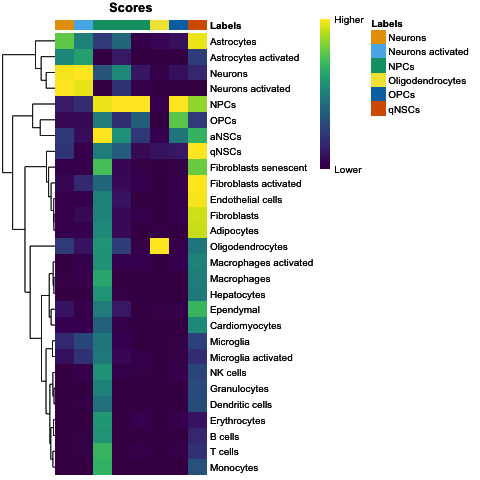

In [139]:
%%R
plotScoreHeatmap(pred)

In [141]:
adata.obs['singleR_anno'] = out['pred.labels']
adata.obs

,wb_anno,wb_conf_score,dev_wb_anno,dev_wb_conf_score,signleR_anno,singleR_anno
1,326 OPC NN,0.999999,Oligodendrocyte: Oligodendrocyte precursor cell,1.000000,Neurons,Neurons
2,326 OPC NN,0.997813,Oligodendrocyte: Oligodendrocyte precursor cell,0.999542,NPCs,NPCs
3,326 OPC NN,0.994119,Oligodendrocyte: Oligodendrocyte precursor cell,1.000000,Neurons activated,Neurons activated
4,326 OPC NN,0.998233,Oligodendrocyte: Oligodendrocyte precursor cell,1.000000,NPCs,NPCs
5,326 OPC NN,0.003595,Vascular: Vascular smooth muscle,1.000000,qNSCs,qNSCs
6,045 OB-STR-CTX Inh IMN,0.819486,Oligodendrocyte: Oligodendrocyte precursor cell,1.000000,NPCs,NPCs
7,326 OPC NN,0.994593,Oligodendrocyte: Oligodendrocyte precursor cell,1.000000,OPCs,OPCs
8,327 Oligo NN,1.000000,Oligodendrocyte: Committed oligodendrocyte pre...,1.000000,Oligodendrocytes,Oligodendrocytes


In [142]:
adata.obs[['wb_anno', 'singleR_anno']]

,wb_anno,singleR_anno
1,326 OPC NN,Neurons
2,326 OPC NN,NPCs
3,326 OPC NN,Neurons activated
4,326 OPC NN,NPCs
5,326 OPC NN,qNSCs
6,045 OB-STR-CTX Inh IMN,NPCs
7,326 OPC NN,OPCs
8,327 Oligo NN,Oligodendrocytes
